In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
path = '/content/drive/MyDrive/H516/data7l.csv'

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, mean
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df= spark.read.csv(path, header=True, inferSchema=True)

In [8]:
df.show()

+---------+-------+--------+--------------+--------------+---------+----------+----------+------------+------------+--------------------+--------------------+----------------+----------+-----+----------+-------+-----------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-------+--------+--------+--------+-------+-------+----------+-------+-------+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|       ID| Source|Severity|    Start_Time|      End_Time|Start_Lat| Start_Lng|   End_Lat|     End_Lng|Distance(mi)|         Description|              Street|            City|    County|State|   Zipcode|Country|   Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|   Bump|Cro

In [9]:
print(df.columns)

['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [10]:
# Display the count of missing values in each column
df.select([col(c).alias(c) for c in df.columns]).summary("count").show()


+-------+------+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+------+------+------+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+------+--------+--------+--------+-------+-------+----------+-------+------+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|summary|    ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|  City|County| State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|  Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|  Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Tw

In [11]:

# Create a DataFrame of Street and their corresponding accident cases
street_df = df.groupBy("Street").count().withColumnRenamed("count", "Cases").orderBy(col("Cases").desc())
top_ten_streets_df = street_df.limit(10).toPandas()


In [12]:
# Display the top 10 accident-prone streets
print(top_ten_streets_df)



    Street  Cases
0    I-5 N  17572
1    I-5 S  12552
2   I-95 N   8788
3   I-10 E   7645
4   I-10 W   7407
5   I-80 E   6795
6   I-95 S   6664
7   I-80 W   6559
8   I-15 N   5792
9  I-405 N   5399


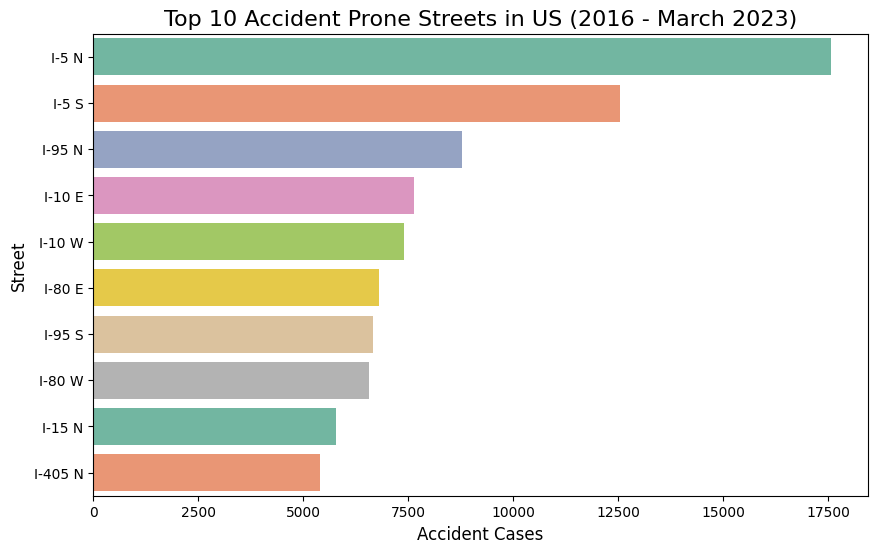

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Cases', y='Street', data=top_ten_streets_df, palette='Set2')
plt.title('Top 10 Accident Prone Streets in US (2016 - March 2023)', fontsize=16)
plt.xlabel('Accident Cases', fontsize=12)
plt.ylabel('Street', fontsize=12)
plt.show()


In [14]:
# Columns to drop
columns_to_drop = ['ID', 'Country', 'Source', 'End_Lat', 'End_Lng', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
df = df.drop(*columns_to_drop)

In [15]:
df.show(5)

+--------+--------------+--------------+---------+----------+------------+--------------------+--------+--------------+---------+-----+----------+-----------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-------+--------+--------+--------+-------+-------+----------+-------+-------+---------------+--------------+------------+--------------+
|Severity|    Start_Time|      End_Time|Start_Lat| Start_Lng|Distance(mi)|         Description|  Street|          City|   County|State|   Zipcode|   Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|   Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|   Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|
+--------+--------------+--------------+---------+--------

In [16]:
! pip install seaborn
import matplotlib.cm as cm
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming 'spark' is your SparkSession and 'df' is your DataFrame

# Define a Window specification over the 'State' column
window_spec = Window.partitionBy('State')

# Calculate the mode (most frequent city) for each 'State' group
mode_cities = F.first(F.col('City')).over(window_spec)

# Fill missing 'City' values with the mode for their respective 'State' group
df = df.withColumn('City', F.when(F.col('City').isNull(), mode_cities).otherwise(F.col('City')))

# Show the DataFrame with updated 'City' column
df.show()


+--------+-------------+--------------+---------+----------+------------+--------------------+------------------+--------+--------+-----+----------+-----------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+
|Severity|   Start_Time|      End_Time|Start_Lat| Start_Lng|Distance(mi)|         Description|            Street|    City|  County|State|   Zipcode|   Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|
+--------+-------------+--------------+---------+----------+--

In [19]:

# List of columns to fill missing values
columns_to_fill = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Wind_Speed(mph)', 'Precipitation(in)']

# Iterate through columns and fill missing values with the mean for their respective 'State' group
for column in columns_to_fill:
    # Calculate the mean for each 'State' group
    state_mean_column = F.mean(column).over(Window.partitionBy('State'))

    # Replace missing values with the mean for their respective 'State' group
    df = df.withColumn(column, F.when(F.col(column).isNull(), state_mean_column).otherwise(F.col(column)))

# Show the DataFrame with updated columns
df.show()


+--------+-------------+--------------+---------+----------+------------+--------------------+------------------+--------+--------+-----+----------+-----------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+
|Severity|   Start_Time|      End_Time|Start_Lat| Start_Lng|Distance(mi)|         Description|            Street|    City|  County|State|   Zipcode|   Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|
+--------+-------------+--------------+---------+----------+--

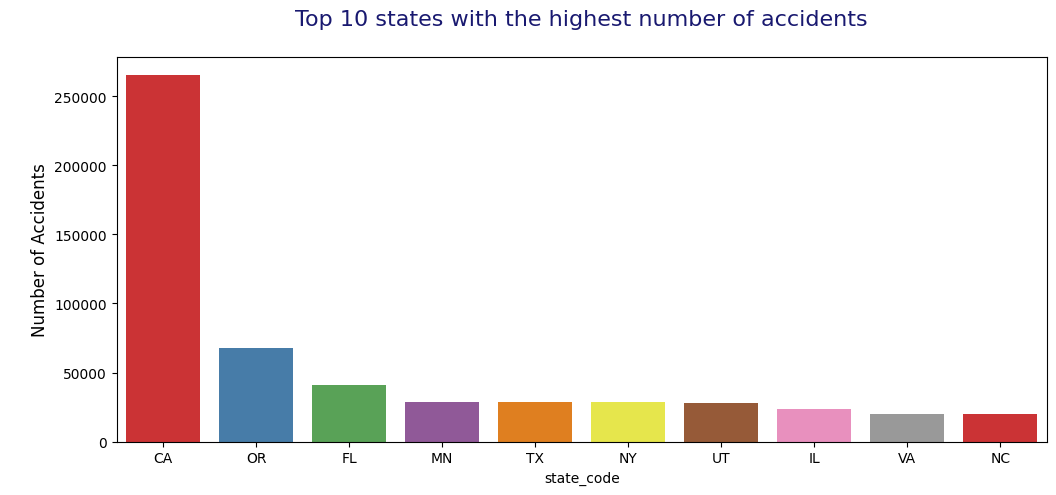

In [20]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


# Group by 'State' and count the occurrences
state_counts = df.groupBy('State').count()

# Rename columns
state_counts = state_counts.withColumnRenamed('State', 'state_code').withColumnRenamed('count', 'cases')

# Order by count in descending order
state_counts = state_counts.orderBy('cases', ascending=False)

# Convert to Pandas DataFrame for plotting
states_pandas = state_counts.limit(10).toPandas()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='state_code', y='cases', data=states_pandas, palette='Set1')
plt.title("Top 10 states with the highest number of accidents\n", fontdict={'fontsize': 16, 'color': 'MidnightBlue'})
plt.ylabel("\nNumber of Accidents", fontdict={'fontsize': 12, 'color': 'black'})
plt.savefig("Top 10 states with the highest number of accidents.png")
plt.show()

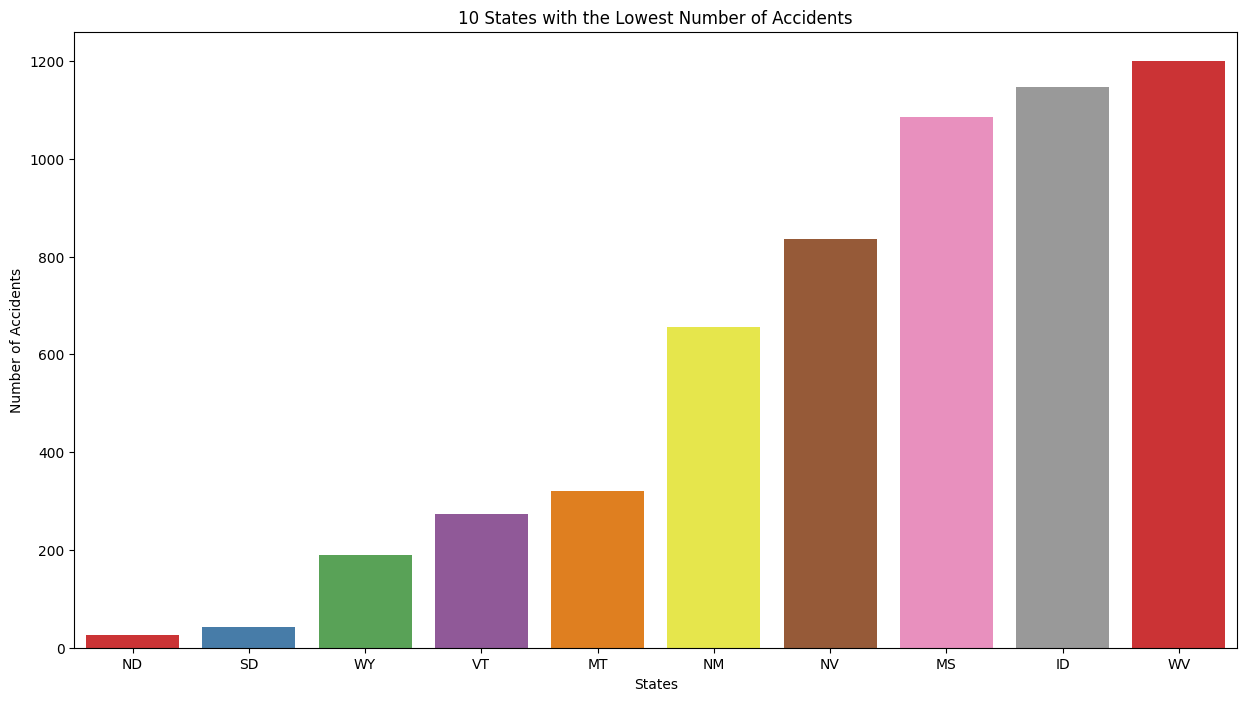

In [21]:
# Create a Spark session
spark = SparkSession.builder.appName("YourAppName").getOrCreate()

# Assuming 'df' is your DataFrame
# Group by 'State' and count the occurrences
state_counts = df.groupBy('State').count()

# Order by count in ascending order
state_counts = state_counts.orderBy('count')

# Limit to the bottom 10 states
bottom_10_states = state_counts.limit(10)

# Convert to Pandas DataFrame for plotting
bottom_10_states_pandas = bottom_10_states.toPandas()

# Plot the bar chart
fig, axs = plt.subplots(figsize=(15, 8))
sns.barplot(x='State', y='count', data=bottom_10_states_pandas, palette='Set1')
axs.set_ylabel("Number of Accidents")
axs.set_xlabel("States")
plt.title("10 States with the Lowest Number of Accidents")
plt.savefig("10 States with the Lowest Number of Accidents.png")
plt.show()


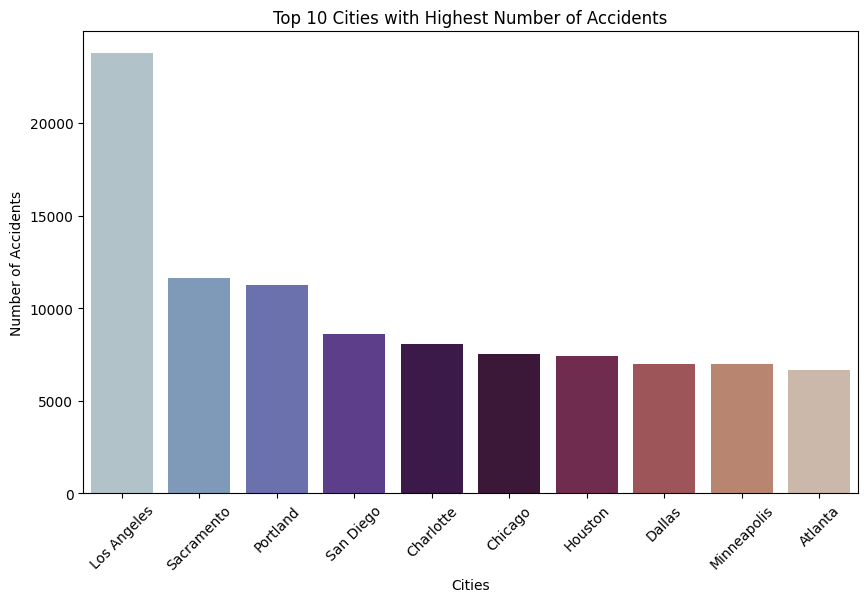

In [22]:

import seaborn as sns

# Create a Spark session
spark = SparkSession.builder.appName("YourAppName").getOrCreate()

# Assuming 'df' is your DataFrame
# Group by 'City' and count the occurrences
city_acc_counts = df.groupBy('City').count()

# Order by count in descending order
city_acc_counts = city_acc_counts.orderBy(col('count').desc())

# Limit to the top 10 cities
top_10_cities = city_acc_counts.limit(10)

# Convert to Pandas DataFrame for plotting
top_10_cities_pandas = top_10_cities.toPandas()

# Plot the bar chart
fig, axs = plt.subplots(figsize=(10, 6))
sns.barplot(x='City', y='count', data=top_10_cities_pandas, palette='twilight')
axs.tick_params(axis='x', rotation=45)
axs.set_ylabel("Number of Accidents")
axs.set_xlabel("Cities")
plt.title("Top 10 Cities with Highest Number of Accidents")
plt.savefig("Top 10 Cities with Highest Number of Accidents.png")
plt.show()


In [57]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
# Select relevant columns
bool_severity_df = df.select('Severity', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
                             'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
                             'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop')

# Group by 'Severity' and sum each boolean column
accidents_by_bool_severity = bool_severity_df.groupBy('Severity').sum()

# Convert to Pandas DataFrame for plotting
accidents_by_bool_severity_pandas = accidents_by_bool_severity.toPandas()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=accidents_by_bool_severity_pandas.set_index('Severity'), cmap='viridis', annot=True, fmt='.1f', linewidths=.5, cbar=False)
plt.title('Accidents by Various Road Features and Severity', fontsize=16)
plt.xlabel('Road Features', fontsize=12)
plt.ylabel('Severity', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Accidents by Various Road Features and Severity.png")
plt.show()


ConnectionRefusedError: ignored

In [26]:
!pip install folium

In [47]:
import pandas as pd
import folium
from folium.plugins import HeatMap

#random_sample = df.sample(n=10000)
# Convert Spark DataFrame to Pandas DataFrame
random_sample = pd.read_csv(r"/content/drive/MyDrive/H516/data7l.csv", nrows = 10000)
# Create a folium map centered at a specific location
m = folium.Map(location=[random_sample['Start_Lat'].mean(), random_sample['Start_Lng'].mean()], zoom_start=4.4)

# Convert your data to a list of coordinates
heatmap_data = random_sample[['Start_Lat', 'Start_Lng']].values.tolist()

# Create a HeatMap layer and add it to the folium map
HeatMap(heatmap_data).add_to(m)

# Display the folium map
m



In [ ]:
import calendar
month_df = pd.DataFrame(object_columns_df.Start_Time_UTC.dt.month.value_counts()).reset_index().rename(columns={'index':'Month', 'Start_Time_UTC':'Cases'})

month_names = list(calendar.month_name)[1:]
month_df['Month'] = month_names

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors

fig, ax = plt.subplots(figsize=(10, 8))

# Change the colormap to 'viridis'
cmap = cm.get_cmap('viridis', 12)
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax = sns.barplot(x=month_df['count'], y=month_df['Month'], palette='rainbow')
plt.title('Road Accident Percentage\nfor different months in US (2016 - March 2023)', size=20, color='grey')
plt.xlabel('Accident Cases')
plt.ylabel('Months')
plt.xlim(0, 800000)
plt.savefig("Road Accident Percentage for different months in US (2016 - March 2023).png")
plt.show()

ConnectionRefusedError: ignored

In [60]:
from pyspark.sql import functions as F
# Assuming 'df' is your DataFrame
min_count = 1000

# Count the occurrences of each Severity value
value_counts = df.groupBy('Severity').count()

# Identify the values to be dropped
to_drop = []
for row in value_counts.collect():
    val, count = row['Severity'], row['count']
    if count > min_count:
        to_drop.extend(df.filter(df['Severity'] == val).sample(withReplacement=False, fraction=(count - min_count) / count).select('index').collect())

# Convert to a list of indices
to_drop_indices = [row['index'] for row in to_drop]

# Filter out the rows with the specified indices
balanced_data = df.filter(~df['index'].isin(to_drop_indices))

# One-hot encode the 'Severity' column
severity_columns = [F.when(F.col('Severity') == val, 1).otherwise(0).alias(f"Severity_{val}") for val in df.select('Severity').distinct().rdd.flatMap(lambda x: x).collect()]
balanced_data = balanced_data.select('*', *severity_columns)

# Combining one-hot encoded columns back to a single column
balanced_data = balanced_data.withColumn("Severity", F.expr("CASE WHEN " + " OR ".join([f"Severity_{val} = 1" for val in df.select('Severity').distinct().rdd.flatMap(lambda x: x).collect()]) + f" THEN '{val}' END"))

# Dropping the individual severity columns
balanced_data = balanced_data.drop(*severity_columns)

# Checking the value counts of the combined Severity column
balanced_data.groupBy('Severity').count().show()

# Checking the shape of the balanced data
print(balanced_data.count(), len(balanced_data.columns))

ConnectionRefusedError: ignored

In [65]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Load your dataset into a DataFrame
# Replace 'your_data.csv' with your actual dataset file
#data = spark.read.csv("/content/drive/MyDrive/H516/data7l.csv", header=True, inferSchema=True)

data = pd.read_csv(r"/content/drive/MyDrive/H516/data7l.csv", nrows = 10000)
# Select relevant features and label column
feature_cols = ['Temperature(F)', 'Wind_Speed(mph)', 'Visibility(mi)']
label_col = 'Severity'

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Create a RandomForest classifier
rf_classifier = RandomForestClassifier(labelCol=label_col, featuresCol='features', numTrees=10)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf_classifier])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Save the model for future use
model.save("accident_severity_model")



ConnectionRefusedError: ignored

ConnectionRefusedError: ignored

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Extract the header (first row) as a list
header = data.first()

# Remove the header row from the data
data = data.filter(col("_c0") != "ID")  # Assuming the first column is "ID"

# Use the extracted header as the new column names
data = data.toDF(*header)

# Display the DataFrame with updated column names
data.show()


In [ ]:
# Display data types
data.dtypes

In [ ]:

data.printSchema()

In [ ]:
# Check for missing values
data.select([col(c).alias(c.replace(' ', '_')) for c in data.columns]).toPandas().isnull().sum()


In [ ]:
# Display summary statistics
data.describe().show()

In [ ]:
# Display the count of each Severity level
data.groupBy("Severity").count().show()


In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Combine numerical features into a vector
feature_cols = ["Start_Lat", "Start_Lng", "Temperature(F)", "Wind_Speed(mph)"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_vectorized = assembler.transform(data)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(data_vectorized, "features").head()

# Show the correlation matrix
print("Correlation matrix:")
print(correlation_matrix[0])


In [ ]:
import pandas as pd
import numpy as np
import os
pwd = os.getcwd()

In [ ]:
df_orig = pd.read_csv('/content/sample_data/tenk.csv')

In [ ]:
df = df_orig.copy()
df

In [ ]:
df.info()

In [ ]:
len(df.columns)

In [ ]:
df.describe()

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.select_dtypes(include=numerics)
print("There are", len(numeric_df.columns), "numeric columns.")

In [ ]:
missing_percentages = df.isna().sum().sort_values(ascending=False) / len(df)

In [ ]:
missing_percentages.round(5)

In [ ]:
missing_percentages[missing_percentages!=0].plot(kind="barh")

In [ ]:
df.isnull().sum()*100/len(df)

In [ ]:
dataset = df.drop(columns=['End_Lat','End_Lng','Wind_Chill(F)','Precipitation(in)','ID','Start_Lat','Start_Lng'],axis=1)
dataset.columns


In [ ]:
dataset.Source.unique()

In [ ]:
#Converting Time figures from abject type to datetime64 type
dataset['Start_Time']=pd.to_datetime(dataset['Start_Time'],format='%Y-%m-%d %H:%M:%S')
dataset['End_Time']=pd.to_datetime(dataset['End_Time'],format='%Y-%m-%d %H:%M:%S')
dataset.head()

In [ ]:
#Generating the target variable
dataset['elapsed_time'] = dataset['End_Time'] - dataset['Start_Time']
dataset['elapsed_time'] = dataset['elapsed_time']/np.timedelta64(1,'m')
dataset.head()

In [ ]:
#Dropping inconsistent Values
dataset = dataset.drop(dataset.loc[dataset.elapsed_time<0].index)

In [ ]:
dataset.groupby(['Source','Severity'])['elapsed_time'].describe(percentiles = [0.20,0.25,0.75,0.80,0.95])

In [ ]:
dataset['day_of_week']=dataset['Start_Time'].dt.weekday
dataset['hour_of_day']=dataset['Start_Time'].dt.hour
dataset['month_of_year']=dataset['Start_Time'].dt.month

In [68]:
df.show(10)

ConnectionRefusedError: ignored

ConnectionRefusedError: ignored